- Author: Harkishan Singh Baniya
- Email: harkishansinghbaniya@gmail.com

# Analysis of Constant Proportion Portfolio Insurance (CPPI) algorithm

In [1]:
#Imports
import time
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style

import alpaca_trade_api as tradeapi

style.use("ggplot")

In [2]:
#Initializing the Alpaca trade API
api_key = #YOUR API KEY
api_secret = #YOUR API SECRET
url = 'https://paper-api.alpaca.markets'
api = tradeapi.REST(api_key, api_secret, base_url=url, api_version='v2')

In [3]:
def get_data(asset_tickers:list, start_date:str, end_date:str, timeframe:str = '1D', get_returns:bool=False) -> pd.DataFrame:
    """
    A function to retrieve historical bars of specified timeframe and return a dataframe of close prices.

    :param start_date : (str) Staring date of the historical period, in format 'YYYY-MM-DD'
    :param end_date   : (str) Ending date of the historical period, in format 'YYYY-MM-DD'
    :param timeframe  : (str) Timeframe of the bars. E.g. - '1Min', '30Min', '1D' etc.
    :param get_returns    : (bool) Whether to return a returns dataframe or not. 
    :return :(pd.DataFrame) A dataframe of the historical bars
    """
    start_date = start_date + 'T00:00:00.000Z'
    end_date = end_date + 'T00:00:00.000Z'
    dataset = []
    if len(asset_tickers) > 100:
        assets = []
        i = 0
        while True:
            assets.append(asset_tickers[i:i+100])
            i +=  100
            if i >= len(asset_tickers):
                break
    else:
        assets = [asset_tickers]
    #Get the OHLCV bars from the REST API as Pandas DataFrame
    for symbol in assets:
        dataset.append(api.get_barset(symbol, timeframe, start=start_date, end=end_date).df.xs('close', level=1, axis=1, drop_level=True))
    dataset = pd.concat(dataset, axis=1).sort_index()
    if get_returns:
        dataset = dataset.pct_change()
    return dataset.dropna()

def run_cppi(risky_returns:pd.Series, safe_returns:pd.Series=None, starting_capital:float=25000, m:int=3, 
             floor_pct:float=0.8, riskfree_rate:float=0.04, periods_per_year:int=255, update_floor:bool=True,
             plot_perf:bool=True) -> pd.DataFrame:
    """
    Function to backtest a CPPI strategy of given settings.
    
    :param risky_returns : (ppd.Series)  returns series of risky asset for the CPPI strategy.
    :param safe_returns : (pd.Series)  returns series of the safe asset. Default is None and will consider
                          the riskfree rate as the safe return. 
    :param starting_capital : (float) the initial capital for the CPPI strategy.
    :param m : (int) the risk mutiplier or risk aversion parameter. A good value will be between 3 and 6. Default is 3.
    :param floor_pct : (float) the floor perecentage or value to perserve of the CPPI strategy. Default is 0.8 or 80%.
    :param riskfree_rate : (float) the risk-free rate for the strategy.
    :param periods_per_year : (int) the period of the strategy per annum. Default is 255 for daily frequency.
    :param update_floor : (bool) if to update the floor and create a dynamic CPPI floor.
    :param plot_perf : (bool) if to plot the performance and backtest summary.
    :return : (pd.DataFrame) results of CPPI parameters and portfolio value.
    """
    #
    risky_asset = risky_returns.name
    # set the CPPI strategy params 
    cppi_value = starting_capital
    floor_value = starting_capital*floor_pct
    max_cppi_value = starting_capital
    
    
    if safe_returns is None:
        rr_per_period = riskfree_rate/periods_per_year #riskfree rate per period
        safe_returns = pd.Series(rr_per_period, index=risky_returns.index)
    
    results = pd.DataFrame(index=risky_returns.index, columns=['cppi value', 'floor', 'risk alloc', 
                                                               'safe alloc', 'risk budget'])
    
    for idx in risky_returns.index:
        if update_floor:
            max_cppi_value = max(max_cppi_value, cppi_value)
            floor_value = max_cppi_value*floor_pct
        cushion = cppi_value - floor_value #this is the cushion or risk budget
        risk_alloc = max(min(m*cushion, cppi_value), 0)
        safe_alloc = cppi_value - risk_alloc
        cppi_value = risk_alloc*(1 + risky_returns.loc[idx]) + safe_alloc*(1 + safe_returns.loc[idx])
        #print(cppi_value)
        results['cppi value'].loc[idx] = cppi_value
        results['floor'].loc[idx] = floor_value
        results['risk alloc'].loc[idx] = risk_alloc
        results['safe alloc'].loc[idx] = safe_alloc
        results['risk budget'].loc[idx] = cushion
    results[risky_asset] = starting_capital*(1+risky_returns).cumprod()
    #get the performance summary 
    summary = [performance_stats(results['cppi value'].pct_change()[1:], periods_per_year, riskfree_rate), 
               performance_stats(results[risky_asset].pct_change()[1:], periods_per_year, riskfree_rate)]
    summary = pd.DataFrame(summary, index=['With CPPI', f'Without CPPI'])
    if plot_perf:
        plot_results(results, benchmark_asset=risky_asset)
    return results, summary

def plot_results(results:pd.DataFrame, benchmark_asset:str):
    """
    Plots the CPPI backtests results.
    """
    results = results.sort_index()
    dates = results.index.values
    start_date = str(dates[0].astype('datetime64[D]'))
    end_date =str(dates[-1].astype('datetime64[D]'))
    fig = plt.figure(figsize=(14, 8))
    plt.plot(dates, results["cppi value"], label='With CPPI')
    plt.plot(dates, results[benchmark_asset], label=f'Without CPPI', color='purple', ls='--', alpha=0.6)
    plt.plot(dates, results["floor"], label='floor',  color="skyblue")
    #plt.fill_between(dates, results["floor"], label='floor', color='skyblue', alpha=0.3)
    plt.title(f"CPPI of {benchmark_asset} from {start_date} to {end_date}")
    plt.xlabel('dates')
    plt.ylabel('price')
    plt.legend()
    plt.show()
    
    
def performance_stats(returns:pd.Series, periods_per_year:int=255, riskfree_rate:float=0.04):
    """
    Calculate the performance metrics from a returns series.
    """
    stats = {}
    cum_ret = (1+returns).prod()
    stats['Cumulative returns'] = f'{round(100*(cum_ret-1), 2)}%'
    #annualized metrics 
    ann_ret = cum_ret**(periods_per_year/returns.shape[0])-1
    ann_vol = returns.std()*(periods_per_year**0.5)
    stats['Annualize returns'] = f'{round(100*ann_ret, 2)}%'
    stats['Annualize volatility'] = f'{round(100*ann_vol, 2)}%'
    #risk metrics 
    stats['Sharpe ratio'] = round((ann_ret - riskfree_rate)/ann_vol , 2)
    #max drawdown
    wealth_index = 1000*(1+returns).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    stats['Max Drawdown'] = f'{round(100*drawdowns.min(), 2)}%'
    #skewness and kurtosis 
    stats['Skewness'] = round(returns.skew(), 2)
    stats['Kurtosis'] = round(returns.kurt(), 2)
    #VaR 
    stats['VaR'] = f'{round(100*-np.percentile(returns, 5) ,2)}%'
    return stats
    
    

In [4]:
start_date = '2015-01-01'
end_date = '2020-12-20'
risky_assets = ['SPY']
#Pulling the returns
df = get_data(risky_assets, start_date, end_date, get_returns=True)
df.head()

,SPY
2015-01-02 00:00:00-05:00,-0.000535
2015-01-05 00:00:00-05:00,-0.017575
2015-01-06 00:00:00-05:00,-0.009812
2015-01-07 00:00:00-05:00,0.012611
2015-01-08 00:00:00-05:00,0.017693


## Without drawdown constraint

Just set the ```update_floor=False```

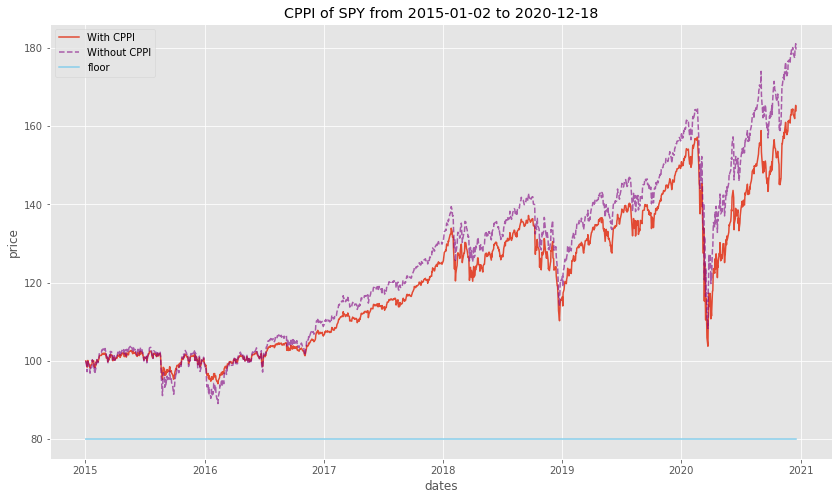

,Cumulative returns,Annualize returns,Annualize volatility,Sharpe ratio,Max Drawdown,Skewness,Kurtosis,VaR
With CPPI,64.01%,8.76%,16.79%,0.28,-34.01%,-1.42,23.57,1.43%
Without CPPI,79.7%,10.46%,18.78%,0.34,-34.23%,-0.67,18.64,1.72%


In [5]:
res, stats = run_cppi(df['SPY'], starting_capital=100, m=3, floor_pct=0.8, riskfree_rate=0.04, periods_per_year=255, 
                      update_floor=False)
stats

## With drawdown constraint

```update_floor=True```, which is default

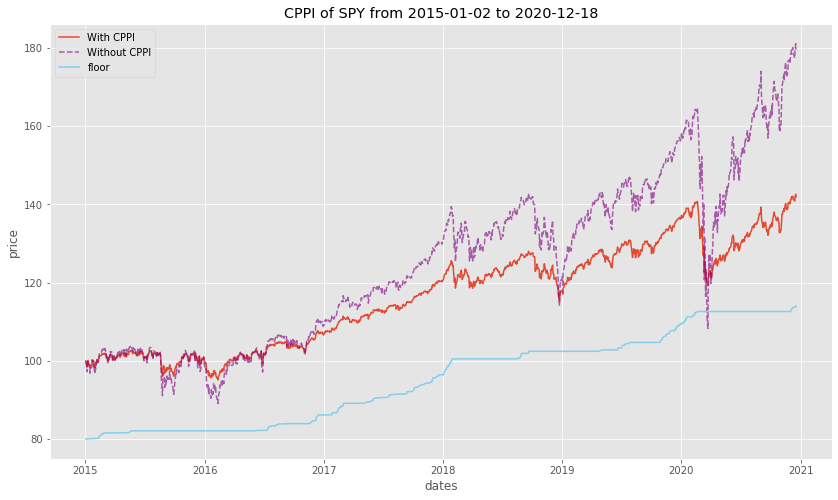

,Cumulative returns,Annualize returns,Annualize volatility,Sharpe ratio,Max Drawdown,Skewness,Kurtosis,VaR
With CPPI,41.93%,6.13%,8.18%,0.26,-15.31%,-1.09,5.90,0.85%
Without CPPI,79.7%,10.46%,18.78%,0.34,-34.23%,-0.67,18.64,1.72%


In [6]:
res, stats = run_cppi(df['SPY'], starting_capital=100, m=3, floor_pct=0.8, riskfree_rate=0.04, periods_per_year=255,
                      update_floor=True)
stats

## CPPI with iShares U.S. Treasury Bond ETF (GOVT) as the safe asset

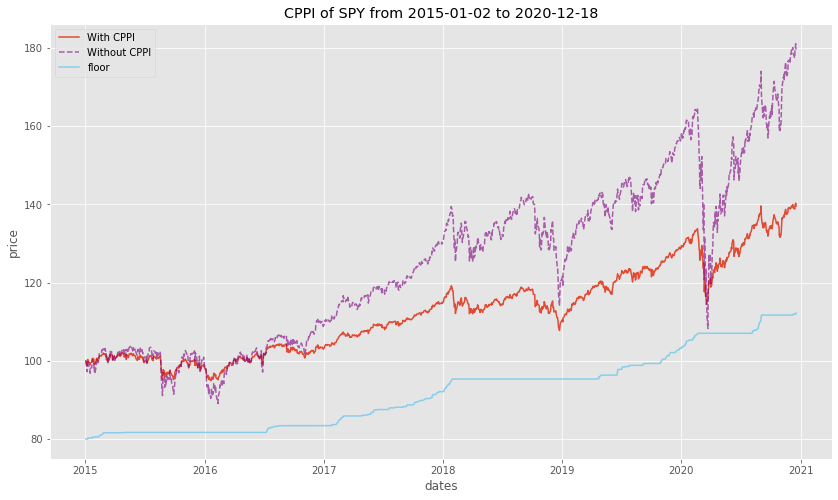

In [7]:
start_date = '2015-01-01'
end_date = '2020-12-20'
df = get_data(['SPY', 'GOVT'], start_date, end_date, get_returns=True)
res, stats = run_cppi(df['SPY'], df['GOVT'], starting_capital=100, m=3, floor_pct=0.8, riskfree_rate=0.04, periods_per_year=255)

In [8]:
stats

,Cumulative returns,Annualize returns,Annualize volatility,Sharpe ratio,Max Drawdown,Skewness,Kurtosis,VaR
With CPPI,39.52%,5.82%,7.79%,0.23,-14.5%,-1.08,6.23,0.76%
Without CPPI,79.7%,10.46%,18.78%,0.34,-34.23%,-0.67,18.64,1.72%


## CPPI on FAANG portfolio

An equally weighted portfolio

In [9]:
start_date = '2019-01-01'
end_date = '2020-12-20'
risky_assets = ['FB', 'AAPL', 'AMZN', 'NFLX', 'GOOG']
faang_df = get_data(risky_assets, start_date, end_date, get_returns=True)
#creating a equally weighted (1/N) portfolio 
weights = np.ones(len(risky_assets)) * 1/len(risky_assets)
faang = faang_df.multiply(1/len(risky_assets), axis=1).sum(1)
faang.name = 'FAANG'

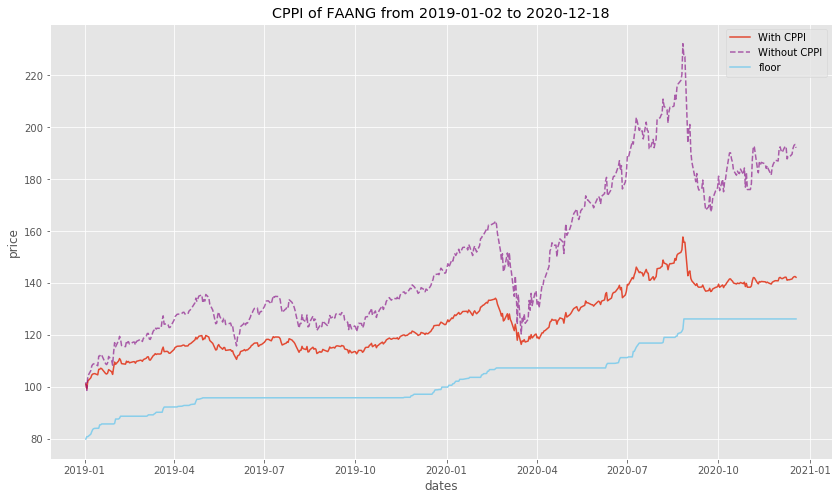

,Cumulative returns,Annualize returns,Annualize volatility,Sharpe ratio,Max Drawdown,Skewness,Kurtosis,VaR
With CPPI,40.67%,19.18%,14.83%,1.02,-13.32%,-1.75,14.17,1.34%
Without CPPI,88.58%,38.56%,32.41%,1.07,-27.86%,-1.12,9.02,3.08%


In [10]:
res, stats = run_cppi(faang, starting_capital=100, m=3, floor_pct=0.8, riskfree_rate=0.04, periods_per_year=255)
stats